In [33]:
import wandb
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [1]:
api = wandb.Api()

NameError: name 'wandb' is not defined

In [99]:
"""
sample size 50: jlkn7dnj
sample size 100: 8g6gp2wm
sample size 200: 0aq5t9in
"""
entity = "opent03-team"
project = "bayesian_dpddm"
sweep_id = "0aq5t9in" 

In [39]:
sweep = api.sweep(f"{entity}/{project}/{sweep_id}")
runs = sweep.runs
data = []

In [40]:
for run in tqdm(runs):
    run_data = {
        "run_id": run.id,
        "name": run.name,
        "state": run.state,
        "config": run.config,
        "metrics": run.summary_metrics,
        "created_at": run.created_at,
    }
    data.append(run_data)

100%|██████████| 947/947 [00:46<00:00, 20.51it/s]


In [41]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Expand nested config and metrics columns
df = df.join(pd.json_normalize(df.pop("config"), sep=".")).join(pd.json_normalize(df.pop("metrics"), sep="."))

# Save DataFrame as CSV
df.to_csv("cifar10_sweep_200.csv", index=False)

print("Sweep data saved to wandb_sweep_results.csv")


Sweep data saved to wandb_sweep_results.csv


In [37]:
data[0]

{'run_id': 'ut7i8x7v',
 'name': 'breezy-sweep-1068',
 'state': 'finished',
 'config': {'dataset': 'cifar10',
  'dpddm.temp': 1,
  'model.hidden_dim': 128,
  'model.mid_layers': 2,
  'model.kernel_size': 7,
  'model.mid_channels': 256,
  'dpddm.data_sample_size': 100,
  'model.reg_weight_factor': 1},
 'metrics': {'Phi-mean': 0.0981399969086051,
  'Phi-med': 0.09999999403953552,
  'Phi-std': 0.016429862692509144,
  '_runtime': 2465.650978088379,
  '_step': 52,
  '_timestamp': 1740590848.489294,
  '_wandb': {'runtime': 2465},
  'dr_ood': [0.11709999687969684, 0.019302590291860627],
  'dr_test': [0.09709999728947878, 0.016449619763345753],
  'dr_train': [0.09769999716430902, 0.017541664432674187],
  'fpr_id': 0.03,
  'fpr_train': 0.07,
  'tpr': 0.33,
  'train_acc': 0.79625,
  'train_loss': 0.666062015581131,
  'val_acc': 0.7500995222929936,
  'val_loss': 0.8022800106911143},
 'created_at': '2025-02-26T16:46:15Z'}

## Analysis

In [19]:
import matplotlib.pyplot as plt

In [20]:
df = pd.read_csv('cifar10_sweep_200.csv')

In [21]:
def get_best_tprs(df, fpr_ub):
    df = df.dropna(subset='tpr')
    new_df = df[df['fpr_id'] <= fpr_ub]
    best_run = new_df.iloc[new_df['tpr'].argmax()]
    return best_run

def plots(df):
    plt.scatter(df['tpr'], df['fpr_id'], c=df['fpr_train'])
    plt.axhline(0.05, c='r')
    

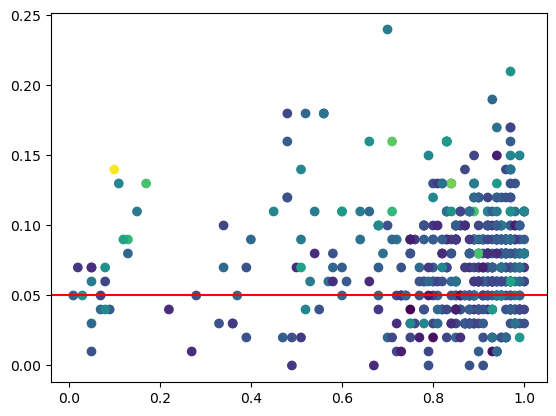

In [22]:
plots(df)

In [23]:
df = df.dropna(subset='tpr')
new_df = df[df['fpr_id'] <= 0.05]
len(new_df)

175

0.6933333333333334


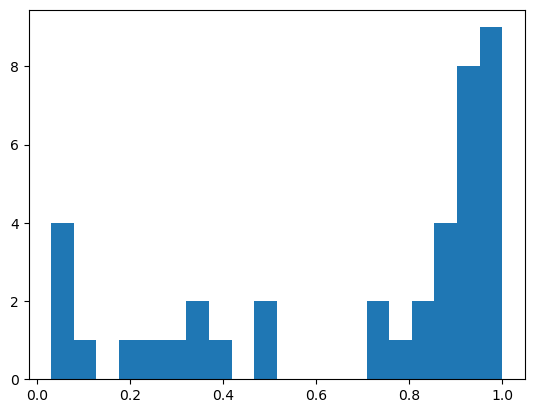

In [35]:
hist_data = new_df[new_df['model.mid_channels'] == 512]['tpr']
plt.hist(hist_data, bins=20)
print(np.mean(hist_data))

0.8451948051948052


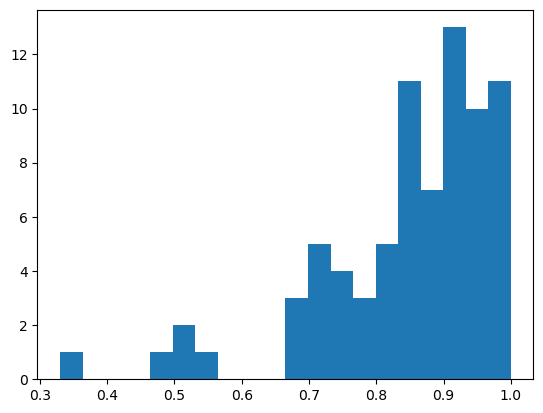

In [36]:
hist_data = new_df[new_df['model.mid_channels'] == 256]['tpr']
plt.hist(hist_data, bins=20)
print(np.mean(hist_data))

0.8666037735849058


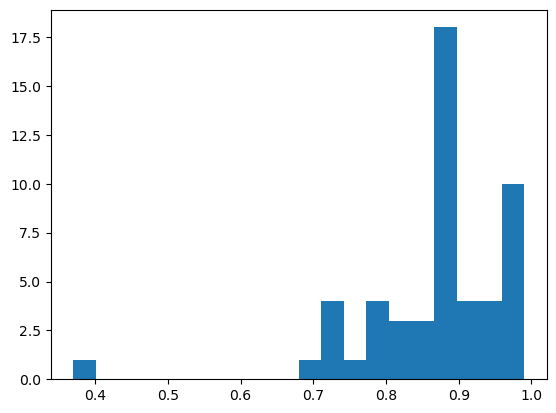

In [37]:
hist_data = new_df[new_df['model.mid_channels'] == 128]['tpr']
plt.hist(hist_data, bins=20)
print(np.mean(hist_data))

In [51]:
best = new_df[new_df.run_id == 'xexqstqs']
print(best)

       run_id              name     state  \
451  xexqstqs  fallen-sweep-496  finished   

                                               metrics            created_at  \
451  {'Phi-mean': 0.12979999624192717, 'Phi-med': 0...  2025-02-26T03:58:11Z   

     dataset  dpddm.temp  model.hidden_dim  model.mid_layers  \
451  cifar10        1000               128                 4   

     model.kernel_size  ...  Phi-mean  Phi-med   Phi-std  \
451                  5  ...    0.1298     0.13  0.014292   

                                         dr_ood  \
451  [0.1782999962568283, 0.013476274840539069]   

                                        dr_test  \
451  [0.12429999642074108, 0.01400035677201967]   

                                        dr_train  fpr_id  fpr_train  tpr  \
451  [0.13024999581277372, 0.014480589548157582]    0.03       0.06  1.0   

     _wandb.runtime  
451          8279.0  

[1 rows x 30 columns]


In [53]:
print(best['model.mid_channels'])
print(best['model.hidden_dim'])
print(best['model.reg_weight_factor'])

451    512
Name: model.mid_channels, dtype: int64
451    128
Name: model.hidden_dim, dtype: int64
451    100
Name: model.reg_weight_factor, dtype: int64


451    128
Name: model.hidden_dim, dtype: int64

In [ ]:
best